# Exploration of the transfer fron semseg to mmseg

## Basic segmentation

In [1]:
from PIL import Image
import torch
from mmseg.apis import inference_segmentor, init_segmentor
import mmseg
import mmcv
import numpy as np
import os

In [28]:
# configuration and checkpoint files
BEIT_CONFIG = "/app/upernet_beit-base_8x2_640x640_160k_ade20k.py"
BEIT_CHECKPOINT = "/app/upernet_beit-base_8x2_640x640_160k_ade20k-eead221d.pth"

# get the color palette used and class names
COLORS = mmseg.core.evaluation.get_palette("ade20k")
CLASS_NAMES = mmseg.core.evaluation.get_classes("ade20k")

# image and output path
image_path = os.path.join("image/boris.jpg")
output_path = os.path.join("output")

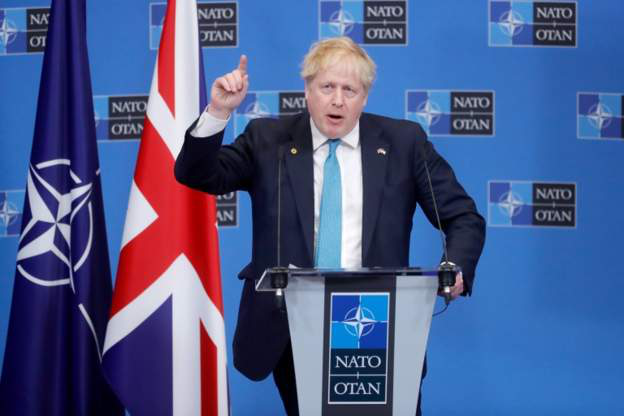

In [4]:
# visualize the initial image
image = Image.open(image_path)
image.show()

In [29]:
model = init_segmentor(BEIT_CONFIG, BEIT_CHECKPOINT, device='cuda:1')

/opt/conda/lib/python3.8/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755903507/work/aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/opt/conda/lib/python3.8/site-packages/mmseg/models/losses/cross_entropy_loss.py:235: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


load checkpoint from local path: /app/upernet_beit-base_8x2_640x640_160k_ade20k-eead221d.pth


In [6]:
image = np.array(image)
result = inference_segmentor(model, image)

In [7]:
result

[array([[ 0,  0,  0, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  0,  0,  0],
        ...,
        [ 0,  0,  0, ...,  0,  0,  0],
        [ 0, 18, 18, ...,  0,  0,  0],
        [18, 18, 18, ...,  0,  0,  0]])]

In [8]:
model.show_result(image, result, out_file = os.path.join(output_path, "overlay_image.png"), opacity = 0.7)

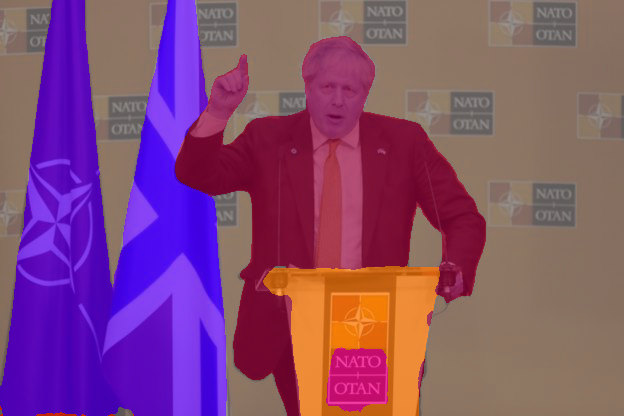

In [9]:
image_overlay = Image.open(os.path.join(output_path, "overlay_image.png"))
image_overlay.show()

We see the segmentation module works pretty well, now we need to extract the contours of the classes found and convert them to SVG

For that we can use the existing code from the previous semantic segmentation model. However, some modifications will probably be needed.

## Extracting the contours

### Contours functions

In [10]:
import numpy as np
import cv2
import mmseg

In [11]:
# custon function to find unique values in the array
def unique(ar, return_index=False, return_inverse=False, return_counts=False):
    ar = np.asanyarray(ar).flatten()

    optional_indices = return_index or return_inverse
    optional_returns = optional_indices or return_counts

    if ar.size == 0:
        if not optional_returns:
            ret = ar
        else:
            ret = (ar,)
            if return_index:
                ret += (np.empty(0, np.bool),)
            if return_inverse:
                ret += (np.empty(0, np.bool),)
            if return_counts:
                ret += (np.empty(0, np.intp),)
        return ret
    if optional_indices:
        perm = ar.argsort(kind='mergesort' if return_index else 'quicksort')
        aux = ar[perm]
    else:
        ar.sort()
        aux = ar
    flag = np.concatenate(([True], aux[1:] != aux[:-1]))

    if not optional_returns:
        ret = aux[flag]
    else:
        ret = (aux[flag],)
        if return_index:
            ret += (perm[flag],)
        if return_inverse:
            iflag = np.cumsum(flag) - 1
            inv_idx = np.empty(ar.shape, dtype=np.intp)
            inv_idx[perm] = iflag
            ret += (inv_idx,)
        if return_counts:
            idx = np.concatenate(np.nonzero(flag) + ([ar.size],))
            ret += (np.diff(idx),)
    return ret



In [30]:
# custom function to replace the label index by its corresponding RGB color vector
def colorEncode(labelmap, colors, mode='RGB'):
    
    labelmap = labelmap.astype(np.int32)
    labelmap_rgb = np.zeros((labelmap.shape[0], labelmap.shape[1], 3), dtype=np.uint8)
    
    labels = unique(labelmap)
    print(f"unique labels : {labels}")
    for label in labels:
        if label < 0:
            continue
        labelmap_rgb += ((labelmap == label)[:, :, np.newaxis] * \
            np.tile(colors[label], (labelmap.shape[0], labelmap.shape[1], 1))).astype(np.uint8)
        print(f"label : {label}, color : {colors[label]}")

    if mode == 'BGR':
        return labelmap_rgb[:, :, ::-1]
    else:
        return labelmap_rgb


In [18]:
# Removes the remaining segments and only highlights the segment of
# interest with a particular color.
def visualize_result(pred, index=None):
    if index is not None:
        pred = pred.copy()
        pred[pred != index] = -1

    logging.info("encoding detected segmets with unique colors")

    # replaces the index of the class with its RGB color
    pred_color = colorEncode(pred, COLORS).astype(np.uint8) 
    object_name = CLASS_NAMES[index]

    return pred_color, object_name

In [16]:
pred = result[0].copy().astype(np.int32)

In [17]:
pred

array([[ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       ...,
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0, 18, 18, ...,  0,  0,  0],
       [18, 18, 18, ...,  0,  0,  0]], dtype=int32)

In [23]:
# most proeminent classes found during the segmentation
predicted_classes = np.bincount(pred.flatten()).argsort()[::-1]
for class_id in predicted_classes[:5]:
            print(f"Class id: {class_id}, Class name: {CLASS_NAMES[class_id]}")

Class id: 0, Class name: wall
Class id: 149, Class name: flag
Class id: 12, Class name: person
Class id: 40, Class name: base
Class id: 43, Class name: signboard


In [31]:
pred_color, class_name = visualize_result(pred, index = predicted_classes[0])

unique labels : [-1  0]
label : 0, colors : [120, 120, 120]


In [33]:
pred_color.shape

(416, 624, 3)

In [36]:
class_name

'wall'

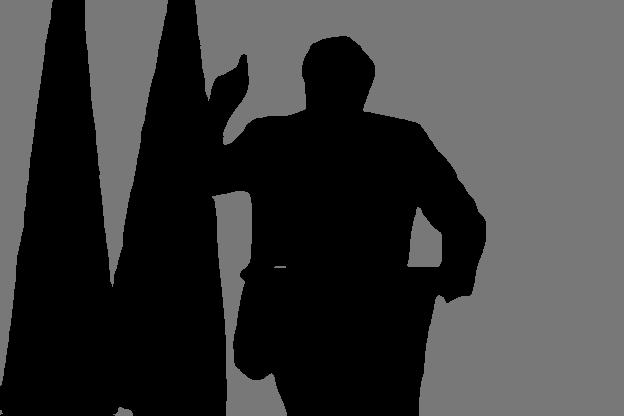

In [35]:
Image.fromarray(pred_color).show()

In [37]:
# takes the colored segment(determined in visualise_result function and
# compressed the segment to 100 pixels
def findContour(pred_color, width, height):
    image = pred_color
    dummy = pred_color.copy()
   
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _ , thresh = cv2.threshold(gray_image, 10, 255, cv2.THRESH_BINARY)

    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    logging.info("Total contours detected are: {}".format(len(contours)))

    cv2.drawContours(image, contours, -1, (0, 255, 0), 2)
    
    # removes the remaining part of image and keeps the contours of segments
    logging.info("deleting remainder of the image except the contours")

    image = image - dummy # TODO : Free dummy memory after this line for optimization
    centres = []
    area = []
    totArea = 0
    send_contour = []
    flag = False

    # calculate the centre and area of individual contours
    logging.info("computing individual contour metrics")

    for i in range(len(contours)):
        moments = cv2.moments(contours[i])

        if moments['m00'] == 0:
            continue
        # if contour area for a given class is very small then omit that
        if cv2.contourArea(contours[i]) < 2000:
            continue

        totArea = totArea + cv2.contourArea(contours[i])
        area.append(cv2.contourArea(contours[i]))
        centres.append(
            (int(moments['m10'] / moments['m00']),
             int(moments['m01'] / moments['m00'])))
        
        area_indi = cv2.contourArea(contours[i])
        centre_indi = (int(moments['m10'] / moments['m00']), int(moments['m01'] / moments['m00']))
        contour_indi = [list(x) for x in contours[i]]
        contour_indi = np.squeeze(contour_indi)
        centre_down = [centre_indi[0] / width, centre_indi[1] / height]
        area_down = area_indi / (width * height)
        
        contour_indi = contour_indi.tolist()
        logging.info("Iterating through individual contours")
        for j in range(len(contour_indi)):
            contour_indi[j][0] = float(float(contour_indi[j][0]) / width)
            contour_indi[j][1] = float(float(contour_indi[j][1]) / height)

        logging.info("End contour iteration ")
        send_contour.append({"coordinates": contour_indi, "centroid": centre_down, "area": area_down})
        
    logging.info("computed all metrics!!")

    if not area:
        flag = True
    else:
        max_value = max(area)
    if flag is True:
        return ([0, 0], [0, 0], 0)
    
    logging.info("generating overall centroid and area")
    centre1 = centres[area.index(max_value)][0] / width
    centre2 = centres[area.index(max_value)][1] / height
    centre = [centre1, centre2]
    totArea = totArea / (width * height)
    result = np.concatenate(contours, dtype=np.float32)

    # if contour is very small then delete it
    if totArea < 0.05:
        return ([0, 0], [0, 0], 0)
    
    result = np.squeeze(result)
    result = np.swapaxes(result, 0, 1)
    result[0] = result[0] / float(width)
    result[1] = result[1] / float(height)
    # send = np.swapaxes(result, 0, 1).tolist()
    return send_contour, centre, totArea

In [43]:
contour, center, totArea = findContour(pred_color, pred_color.shape[1], pred_color.shape[0])

In [41]:
len(contour)

4

In [42]:
contour[0].keys()

dict_keys(['coordinates', 'centroid', 'area'])

It would be great to visualize the contours obtained but it's not possible at the moment inside of the code. We need to get the results of the svgsemseg handler, then extract the svg paths of the contours, then embed them into the html template, which we can display in any browser.

Now that the find_contours function works, the rest is just about setting up the flask app.

## Test on actual request 

In [13]:
import json
import base64
import cv2

In [4]:
with open("request.json", "r") as f:
    request = json.load(f)

In [5]:
request.keys()

dict_keys(['request_uuid', 'timestamp', 'graphic', 'dimensions', 'context', 'language', 'capabilities', 'renderers', 'preprocessors'])

In [7]:
img_b64 = request["graphic"].split(",")[1]

In [35]:
binary = base64.b64decode(img_b64)
image = np.asarray(bytearray(binary), dtype="uint8")
image_np = cv2.imdecode(image, cv2.IMREAD_COLOR)
print(type(image_np))

<class 'numpy.ndarray'>


In [19]:
image_np.shape

(4288, 2848, 3)

In [23]:
height, width, channels = image_np.shape
scale_factor = float(1500.0 / float(max(height, width)))
print(scale_factor)

0.3498134328358209


In [24]:
img = mmcv.imrescale(image_np, scale_factor)

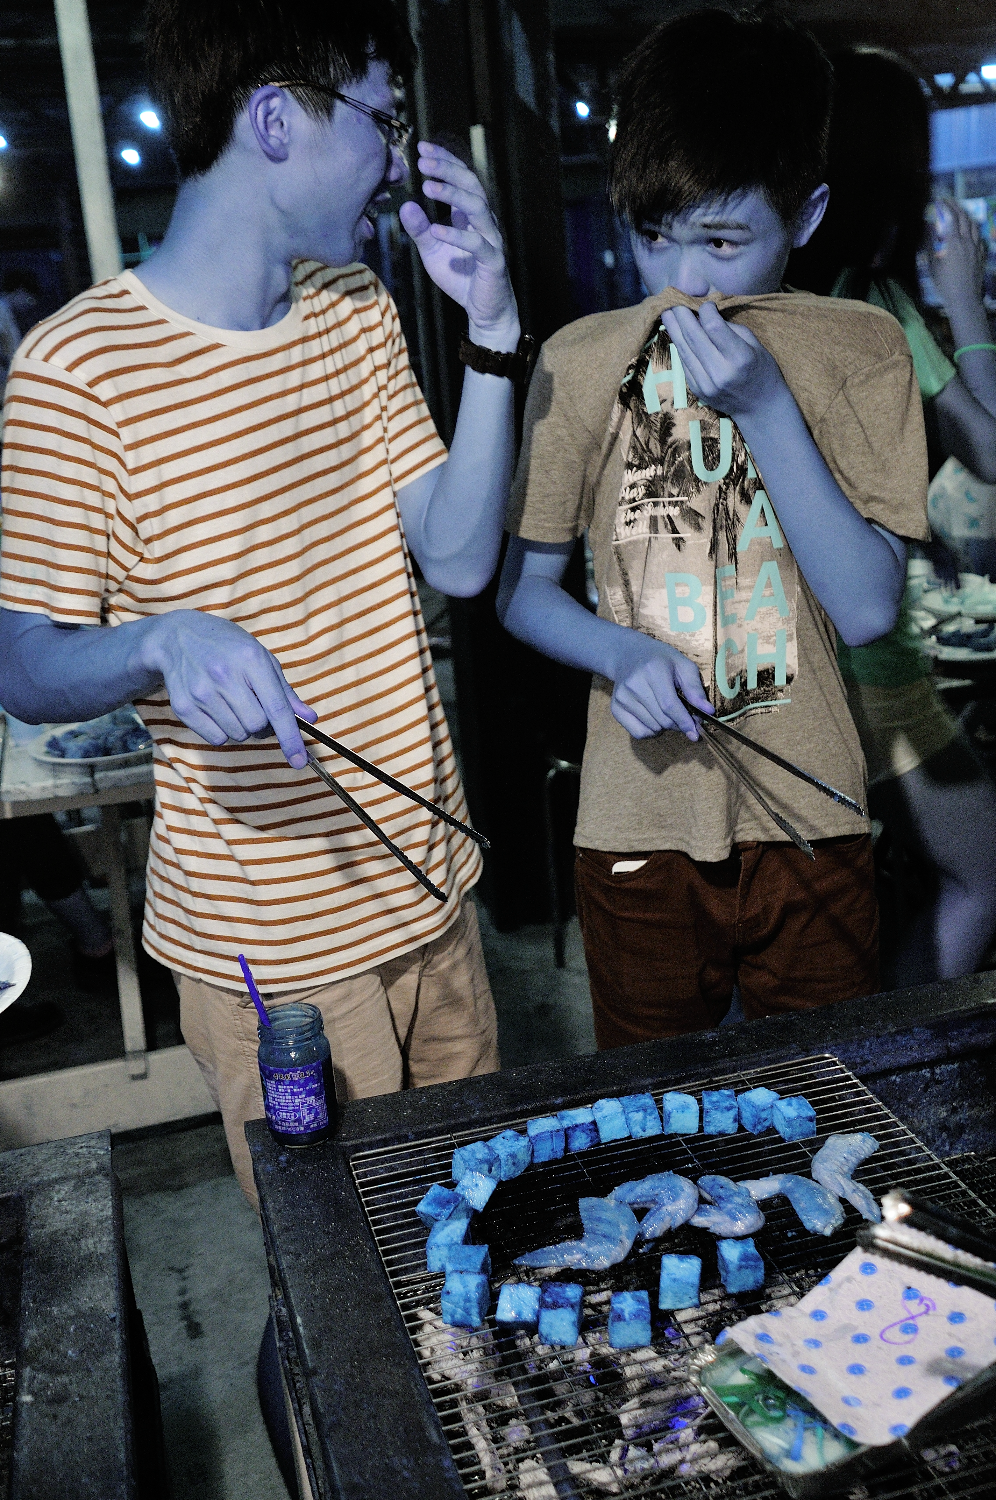

In [26]:
Image.fromarray(img).show()

Why is the image blue-ish ? It could interfere with the segmentation model

In [27]:
img.shape

(1500, 996, 3)

In [30]:
result = inference_segmentor(model, img)

In [32]:
model.show_result(img, result, out_file=os.path.join("output", f"request_overlayed.png"), opacity=0.7)

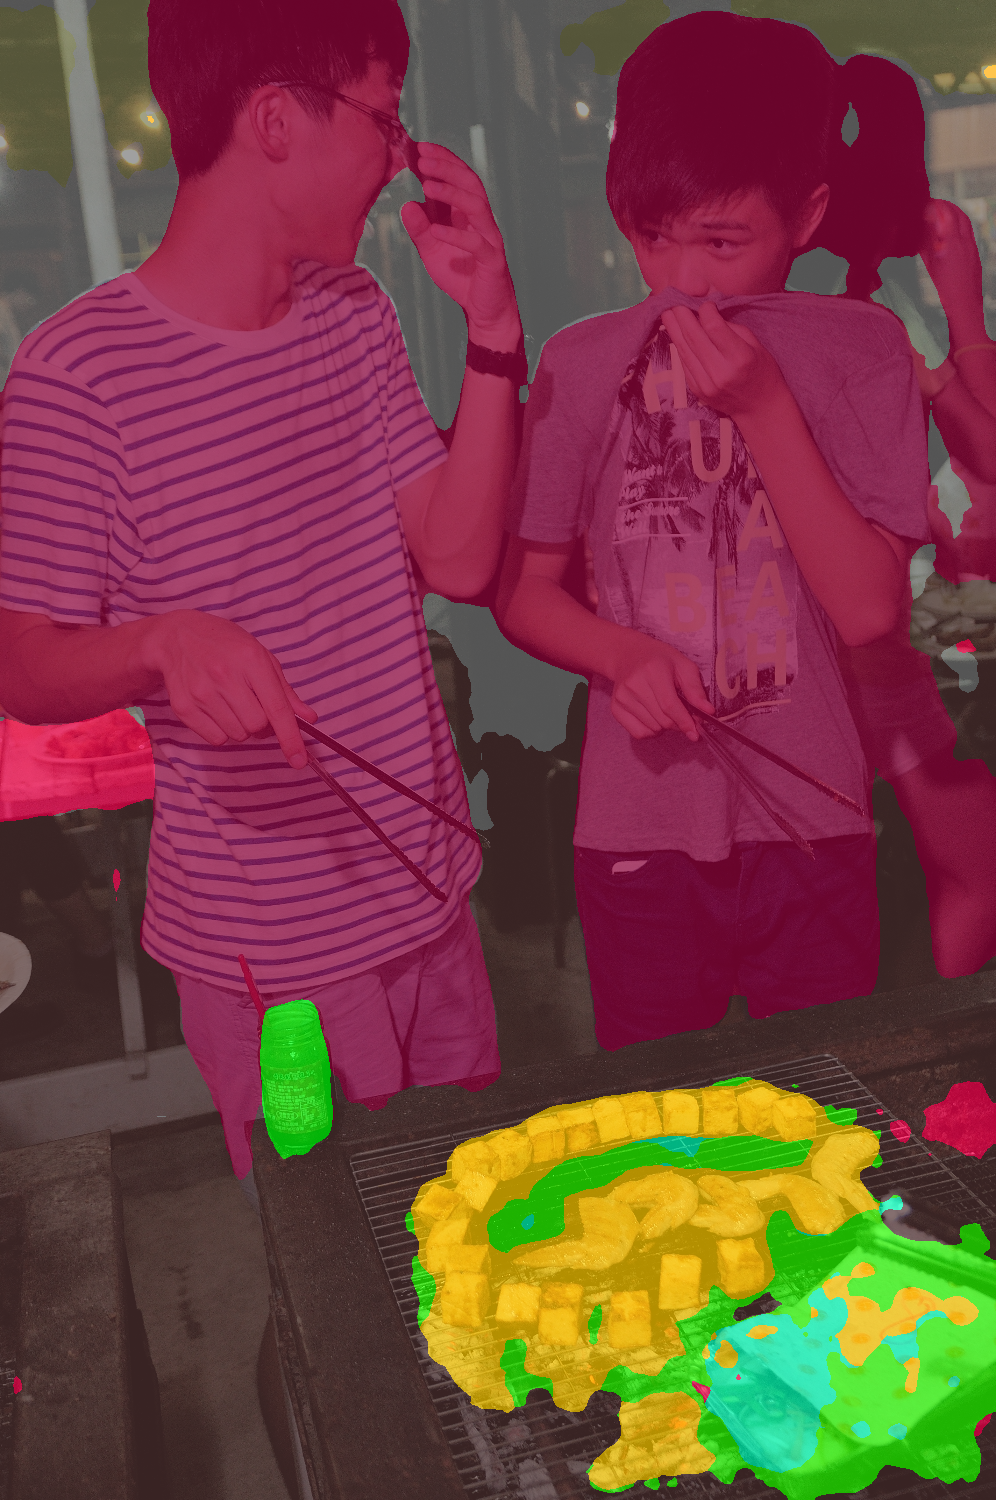

In [33]:
image_overlay = Image.open(os.path.join("output", "request_overlayed.png"))
image_overlay.show()